# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
        del X_train, y_train
        del X_test, y_test
        print('Clear previously loaded data.')
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin = num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
X_train_feats.shape

(49000, 155)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
import pandas as pd
learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# num_tuning = 10
# learning_rates_ = np.exp(np.random.uniform(np.log(learning_rates[0]), np.log(learning_rates[1]), num_tuning))
# regularization_strengths_ = np.exp(np.random.uniform(
#     np.log(regularization_strengths[0]), 
#     np.log(regularization_strengths[1]), 
#     num_tuning
# ))

t = time.time()
# for i in range(num_tuning):
#     for j in range(num_tuning):
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        tic = time.time()
#         learning_rate = learning_rates_[i]
#         reg = regularization_strengths_[j]
        svm = LinearSVM()        
        loss_hist = svm.train(
            X_train_feats, y_train, learning_rate = learning_rate, reg = reg, num_iters = 1500, verbose = False
        )
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        accuracy_train = np.mean(y_train == y_train_pred)
        accuracy_val = np.mean(y_val == y_val_pred)
        results[(learning_rate, reg)] = (accuracy_train, accuracy_val)
        if accuracy_val > best_val: best_val, best_svm = accuracy_val, svm
        toc = round(time.time() - tic, 2)
        
        acc = round(accuracy_val, 2)
        #print('{}-{}: Accuracy {}{}. That took {}{} sec.'.format(i, j, ' ' * (4 - len(str(acc))), acc, ' ' * (6 - len(str(toc))), toc))
        print('Accuracy {}{}. That took {}{} sec.'.format(' ' * (4 - len(str(acc))), acc, ' ' * (6 - len(str(toc))), toc))

print('Total time: {} sec.'.format(round(time.time() - t, 2)))



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Accuracy 0.12. That took   0.51 sec.
Accuracy 0.12. That took   0.48 sec.
Accuracy 0.42. That took   0.44 sec.
Accuracy 0.11. That took   0.43 sec.
Accuracy 0.42. That took   0.42 sec.
Accuracy  0.4. That took   0.44 sec.
Accuracy 0.42. That took   0.42 sec.
Accuracy 0.38. That took   0.44 sec.
Accuracy 0.34. That took   0.42 sec.
Total time: 4.01 sec.
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.110306 val accuracy: 0.124000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.099612 val accuracy: 0.124000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.418061 val accuracy: 0.419000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.116592 val accuracy: 0.107000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.415490 val accuracy: 0.420000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.399327 val accuracy: 0.395000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.417184 val accuracy: 0.422000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.396388 val accuracy: 0.3830

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.42


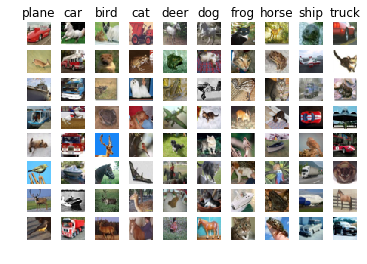

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [9]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
t = time.time()
best_val = -1
best_hp = None
best_stats = None
info = pd.DataFrame(columns = ['l_rate', 'reg', 'hidden_dim', 'accuracy_train', 'accuracy_val'])

# hyperparameters
learning_rates = [8e-2, 1e-1, 13e-2, 2e-1, 4e-1, 1]
regularization_strengths = [0.00005, 0.0005, 0.001, 0.005, 0.01, 0.05]
hidden_dims = [20, 50, 100, 200, 500, 1000]

n1, n2, n3 = len(learning_rates), len(regularization_strengths), len(hidden_dims)

for i in range(n1 * n2 * n3):
    tic = time.time()

    l_rate = learning_rates[i // (n2 * n3)]
    ind1 = i % (n2 * n3) // n3
    reg = regularization_strengths[ind1]
    ind2 = i % (n2 * n3) % n3
    hidden_dim = hidden_dims[ind2]
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)       
    stats = net.train(
        X_train_feats, y_train, X_val_feats, y_val,
        num_iters = 1000, batch_size = 200, learning_rate = l_rate, learning_rate_decay = 0.95,
        reg = reg, verbose = False
    )
        
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    accuracy_train = np.mean(y_train == y_train_pred)
    accuracy_val = np.mean(y_val == y_val_pred)
        
    if accuracy_val > best_val: 
        best_val, best_net, best_hp, best_stats = accuracy_val, net, (l_rate, reg, hidden_dim), stats
    
    step = {
        'l_rate': [l_rate], 'reg': reg, 'hidden_dim': hidden_dim,
        'accuracy_train': accuracy_train, 'accuracy_val': accuracy_val
    }
    info = info.append(pd.DataFrame(step), ignore_index = True)
    
    acc = round(accuracy_val, 2)
    to_print = '{}{}. learning_rate = {} | reg = {}{} | '.format(' ' * (4 - len(str(i))), i, l_rate, reg, ' ' * (6 - len(str(reg))))
    to_print = to_print + 'hidden dimension = {}{}: '.format(' ' * (4 - len(str(hidden_dim))), hidden_dim)    
    to_print = to_print + 'Accuracy {}{}.'.format(' ' * (4 - len(str(acc))), acc)
    toc = round(time.time() - tic, 2)
    if i % (n2 * n3) == 0 and i != 0: print ()
    print('{} That took {}{} sec.'.format(to_print, ' ' * (6 - len(str(toc))), toc))
tt = round(time.time() - t, 0)
print('Total time: {} min. {} sec.'.format(tt // 60, tt % 60))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


   0. learning_rate = 0.08 | reg = 5e-05  | hidden dimension =   20: Accuracy 0.49. That took   0.85 sec.
   1. learning_rate = 0.08 | reg = 5e-05  | hidden dimension =   50: Accuracy 0.47. That took   1.62 sec.
   2. learning_rate = 0.08 | reg = 5e-05  | hidden dimension =  100: Accuracy 0.49. That took   3.01 sec.
   3. learning_rate = 0.08 | reg = 5e-05  | hidden dimension =  200: Accuracy  0.5. That took   5.14 sec.
   4. learning_rate = 0.08 | reg = 5e-05  | hidden dimension =  500: Accuracy  0.5. That took   8.68 sec.
   5. learning_rate = 0.08 | reg = 5e-05  | hidden dimension = 1000: Accuracy 0.51. That took  10.65 sec.
   6. learning_rate = 0.08 | reg = 0.0005 | hidden dimension =   20: Accuracy 0.48. That took    1.2 sec.
   7. learning_rate = 0.08 | reg = 0.0005 | hidden dimension =   50: Accuracy 0.49. That took   1.61 sec.
   8. learning_rate = 0.08 | reg = 0.0005 | hidden dimension =  100: Accuracy 0.49. That took   2.43 sec.
   9. learning_rate = 0.08 | reg = 0.0005 | hi

  78. learning_rate = 0.13 | reg = 0.0005 | hidden dimension =   20: Accuracy 0.51. That took   0.99 sec.
  79. learning_rate = 0.13 | reg = 0.0005 | hidden dimension =   50: Accuracy  0.5. That took   1.33 sec.
  80. learning_rate = 0.13 | reg = 0.0005 | hidden dimension =  100: Accuracy 0.52. That took   2.28 sec.
  81. learning_rate = 0.13 | reg = 0.0005 | hidden dimension =  200: Accuracy  0.5. That took   3.25 sec.
  82. learning_rate = 0.13 | reg = 0.0005 | hidden dimension =  500: Accuracy 0.51. That took   6.47 sec.
  83. learning_rate = 0.13 | reg = 0.0005 | hidden dimension = 1000: Accuracy 0.53. That took  11.96 sec.
  84. learning_rate = 0.13 | reg = 0.001  | hidden dimension =   20: Accuracy 0.52. That took   1.15 sec.
  85. learning_rate = 0.13 | reg = 0.001  | hidden dimension =   50: Accuracy 0.51. That took   1.59 sec.
  86. learning_rate = 0.13 | reg = 0.001  | hidden dimension =  100: Accuracy 0.53. That took   2.28 sec.
  87. learning_rate = 0.13 | reg = 0.001  | hi

 156. learning_rate = 0.4 | reg = 0.001  | hidden dimension =   20: Accuracy 0.52. That took   1.14 sec.
 157. learning_rate = 0.4 | reg = 0.001  | hidden dimension =   50: Accuracy 0.54. That took   1.55 sec.
 158. learning_rate = 0.4 | reg = 0.001  | hidden dimension =  100: Accuracy 0.57. That took    2.3 sec.
 159. learning_rate = 0.4 | reg = 0.001  | hidden dimension =  200: Accuracy 0.56. That took   3.25 sec.
 160. learning_rate = 0.4 | reg = 0.001  | hidden dimension =  500: Accuracy 0.57. That took   7.14 sec.
 161. learning_rate = 0.4 | reg = 0.001  | hidden dimension = 1000: Accuracy 0.56. That took  11.95 sec.
 162. learning_rate = 0.4 | reg = 0.005  | hidden dimension =   20: Accuracy 0.52. That took   1.14 sec.
 163. learning_rate = 0.4 | reg = 0.005  | hidden dimension =   50: Accuracy 0.51. That took   1.59 sec.
 164. learning_rate = 0.4 | reg = 0.005  | hidden dimension =  100: Accuracy 0.54. That took   2.31 sec.
 165. learning_rate = 0.4 | reg = 0.005  | hidden dimen

In [10]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)
print(best_hp)

0.544
(1, 0.0005, 500)


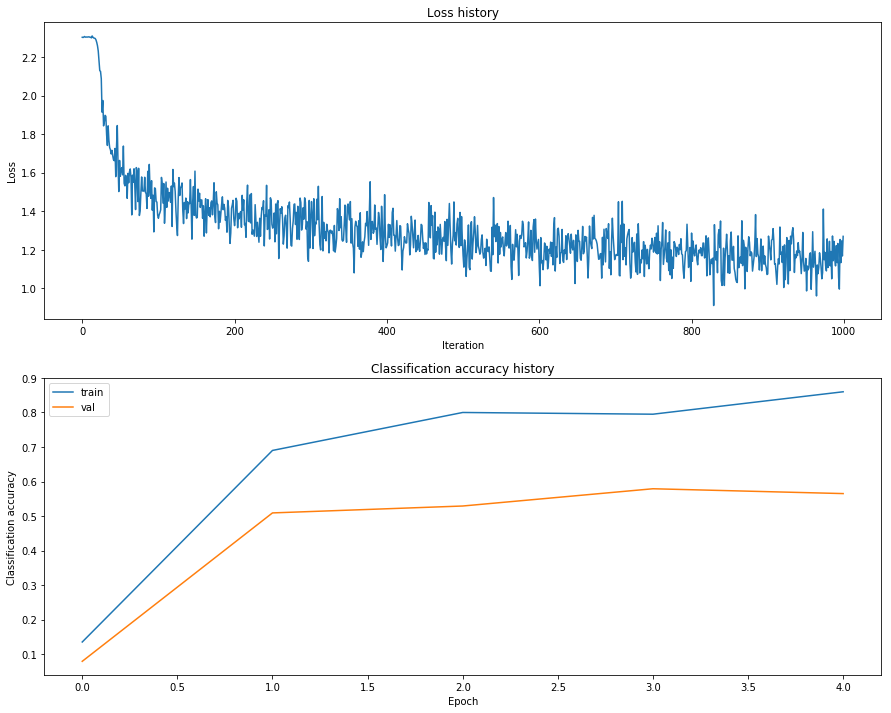

In [11]:
# Plot the loss function and train / validation accuracies
plt.figure(figsize = (15, 12)) # added by me

plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [12]:
cond = (info['accuracy_val'] >= 0.53) & (info['accuracy_train'] >= 0.53)
print(info.loc[cond].sort_values(by = 'accuracy_val', ascending = False).to_string())

     l_rate      reg hidden_dim  accuracy_train  accuracy_val
190    1.00  0.00050        500        0.655837         0.581
149    0.40  0.00005       1000        0.627367         0.578
154    0.40  0.00050        500        0.608776         0.575
195    1.00  0.00100        200        0.623143         0.572
194    1.00  0.00100        100        0.596245         0.572
148    0.40  0.00005        500        0.616714         0.572
155    0.40  0.00050       1000        0.611449         0.572
197    1.00  0.00100       1000        0.632755         0.568
160    0.40  0.00100        500        0.603041         0.567
158    0.40  0.00100        100        0.586694         0.566
159    0.40  0.00100        200        0.593327         0.565
146    0.40  0.00005        100        0.594245         0.565
188    1.00  0.00050        100        0.608367         0.564
153    0.40  0.00050        200        0.603490         0.564
184    1.00  0.00005        500        0.678367         0.563
185    1

In [13]:
info.loc[cond, 'l_rate'].value_counts()

0.40    18
1.00    16
0.20     8
0.13     1
Name: l_rate, dtype: int64

In [14]:
info.loc[cond, 'reg'].value_counts()

0.00005    15
0.00100    12
0.00050    12
0.00500     4
Name: reg, dtype: int64

In [15]:
info.loc[cond, 'hidden_dim'].value_counts()

1000    12
500     10
100      8
200      7
50       4
20       2
Name: hidden_dim, dtype: int64

In [30]:
# additional parameters fitting
t = time.time()
best_val = -1
best_hp = None
best_stats = None
info = pd.DataFrame(columns = ['l_rate', 'reg', 'hidden_dim', 'accuracy_train', 'accuracy_val'])

# hyperparameters
learning_rates = [0.3, 0.4, 0.7, 1, 1.2]
regularization_strengths = [0.00005, 0.0001, 0.0003, 0.0005, 0.001, 0.002]
hidden_dims = [400, 600, 800, 1200]

n1, n2, n3 = len(learning_rates), len(regularization_strengths), len(hidden_dims)

for i in range(n1 * n2 * n3):
    tic = time.time()

    l_rate = learning_rates[i // (n2 * n3)]
    ind1 = i % (n2 * n3) // n3
    reg = regularization_strengths[ind1]
    ind2 = i % (n2 * n3) % n3
    hidden_dim = hidden_dims[ind2]
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)       
    stats = net.train(
        X_train_feats, y_train, X_val_feats, y_val,
        num_iters = 1000, batch_size = 200, learning_rate = l_rate, learning_rate_decay = 0.95,
        reg = reg, verbose = False
    )
        
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    accuracy_train = np.mean(y_train == y_train_pred)
    accuracy_val = np.mean(y_val == y_val_pred)
        
    if accuracy_val > best_val: 
        best_val, best_net, best_hp, best_stats = accuracy_val, net, (l_rate, reg, hidden_dim), stats
    
    step = {
        'l_rate': [l_rate], 'reg': reg, 'hidden_dim': hidden_dim,
        'accuracy_train': accuracy_train, 'accuracy_val': accuracy_val
    }
    info = info.append(pd.DataFrame(step), ignore_index = True)
    
    acc = round(accuracy_val, 3)
    to_print = '{}{}. learning_rate = {} | reg = {}{} | '.format(' ' * (4 - len(str(i))), i, l_rate, reg, ' ' * (7 - len(str(reg))))
    to_print = to_print + 'hidden dimension = {}{}: '.format(' ' * (4 - len(str(hidden_dim))), hidden_dim)    
    to_print = to_print + 'Accuracy {}{}.'.format(' ' * (5 - len(str(acc))), acc)
    toc = round(time.time() - tic, 2)
    if i % (n2 * n3) == 0 and i != 0: print ()
    print('{} That took {}{} sec.'.format(to_print, ' ' * (6 - len(str(toc))), toc))
tt = round(time.time() - t, 0)
print('Total time: {} min. {} sec.'.format(tt // 60, tt % 60))

   0. learning_rate = 0.3 | reg = 5e-05   | hidden dimension =  400: Accuracy 0.561. That took   8.06 sec.
   1. learning_rate = 0.3 | reg = 5e-05   | hidden dimension =  600: Accuracy 0.564. That took   9.78 sec.
   2. learning_rate = 0.3 | reg = 5e-05   | hidden dimension =  800: Accuracy 0.549. That took  13.33 sec.
   3. learning_rate = 0.3 | reg = 5e-05   | hidden dimension = 1200: Accuracy 0.564. That took   22.5 sec.
   4. learning_rate = 0.3 | reg = 0.0001  | hidden dimension =  400: Accuracy 0.559. That took    7.1 sec.
   5. learning_rate = 0.3 | reg = 0.0001  | hidden dimension =  600: Accuracy 0.566. That took   9.82 sec.
   6. learning_rate = 0.3 | reg = 0.0001  | hidden dimension =  800: Accuracy 0.569. That took  12.29 sec.
   7. learning_rate = 0.3 | reg = 0.0001  | hidden dimension = 1200: Accuracy 0.578. That took  17.72 sec.
   8. learning_rate = 0.3 | reg = 0.0003  | hidden dimension =  400: Accuracy 0.556. That took   7.39 sec.
   9. learning_rate = 0.3 | reg = 0.0

  77. learning_rate = 1 | reg = 0.0001  | hidden dimension =  600: Accuracy 0.548. That took   7.46 sec.
  78. learning_rate = 1 | reg = 0.0001  | hidden dimension =  800: Accuracy 0.582. That took   9.46 sec.
  79. learning_rate = 1 | reg = 0.0001  | hidden dimension = 1200: Accuracy 0.569. That took  13.71 sec.
  80. learning_rate = 1 | reg = 0.0003  | hidden dimension =  400: Accuracy  0.57. That took   5.48 sec.
  81. learning_rate = 1 | reg = 0.0003  | hidden dimension =  600: Accuracy 0.548. That took   7.42 sec.
  82. learning_rate = 1 | reg = 0.0003  | hidden dimension =  800: Accuracy  0.55. That took   9.43 sec.
  83. learning_rate = 1 | reg = 0.0003  | hidden dimension = 1200: Accuracy 0.573. That took  13.85 sec.
  84. learning_rate = 1 | reg = 0.0005  | hidden dimension =  400: Accuracy 0.577. That took   5.54 sec.
  85. learning_rate = 1 | reg = 0.0005  | hidden dimension =  600: Accuracy 0.556. That took    7.4 sec.
  86. learning_rate = 1 | reg = 0.0005  | hidden dimens

In [31]:
cond = (info['accuracy_val'] >= 0.57) & (info['accuracy_train'] >= 0.57)
print(info.loc[cond].sort_values(by = 'accuracy_val', ascending = False).to_string())

     l_rate      reg hidden_dim  accuracy_train  accuracy_val
103     1.2  0.00010       1200        0.692878         0.591
88      1.0  0.00100        400        0.634102         0.591
75      1.0  0.00005       1200        0.684041         0.589
34      0.4  0.00030        800        0.621490         0.588
53      0.7  0.00010        600        0.662061         0.586
35      0.4  0.00030       1200        0.616061         0.585
63      0.7  0.00050       1200        0.652633         0.584
27      0.4  0.00005       1200        0.620857         0.584
42      0.4  0.00100        800        0.606122         0.584
78      1.0  0.00010        800        0.676776         0.582
61      0.7  0.00050        600        0.640122         0.582
31      0.4  0.00010       1200        0.624102         0.582
68      0.7  0.00200        400        0.596837         0.581
94      1.0  0.00200        800        0.607714         0.581
30      0.4  0.00010        800        0.620245         0.580
28      

In [19]:
info.loc[cond, 'l_rate'].value_counts()

0.4    12
1.0    12
0.7    11
1.2     7
0.3     5
Name: l_rate, dtype: int64

In [20]:
info.loc[cond, 'reg'].value_counts()

0.00010    13
0.00005    11
0.00050    10
0.00030     7
0.00100     4
0.00200     2
Name: reg, dtype: int64

In [21]:
info.loc[cond, 'hidden_dim'].value_counts()

1200    16
800     10
200      8
600      7
400      6
Name: hidden_dim, dtype: int64

In [22]:
# additional parameters fitting
t = time.time()
best_val = -1
best_hp = None
best_stats = None
info = pd.DataFrame(columns = ['l_rate', 'reg', 'hidden_dim', 'accuracy_train', 'accuracy_val'])

# hyperparameters
learning_rates = [0.4, 0.7, 1]
regularization_strengths = [0.00007, 0.00015, 0.00035, 0.00055]
hidden_dims = [800, 1000, 1200, 1400]

n1, n2, n3 = len(learning_rates), len(regularization_strengths), len(hidden_dims)

for i in range(n1 * n2 * n3):
    tic = time.time()

    l_rate = learning_rates[i // (n2 * n3)]
    ind1 = i % (n2 * n3) // n3
    reg = regularization_strengths[ind1]
    ind2 = i % (n2 * n3) % n3
    hidden_dim = hidden_dims[ind2]
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)       
    stats = net.train(
        X_train_feats, y_train, X_val_feats, y_val,
        num_iters = 1000, batch_size = 200, learning_rate = l_rate, learning_rate_decay = 0.95,
        reg = reg, verbose = False
    )
        
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    accuracy_train = np.mean(y_train == y_train_pred)
    accuracy_val = np.mean(y_val == y_val_pred)
        
    if accuracy_val > best_val: 
        best_val, best_net, best_hp, best_stats = accuracy_val, net, (l_rate, reg, hidden_dim), stats
    
    step = {
        'l_rate': [l_rate], 'reg': reg, 'hidden_dim': hidden_dim,
        'accuracy_train': accuracy_train, 'accuracy_val': accuracy_val
    }
    info = info.append(pd.DataFrame(step), ignore_index = True)
    
    acc = round(accuracy_val, 3)
    to_print = '{}{}. learning_rate = {} | reg = {}{} | '.format(' ' * (4 - len(str(i))), i, l_rate, reg, ' ' * (6 - len(str(reg))))
    to_print = to_print + 'hidden dimension = {}{}: '.format(' ' * (4 - len(str(hidden_dim))), hidden_dim)    
    to_print = to_print + 'Accuracy {}{}.'.format(' ' * (5 - len(str(acc))), acc)
    toc = round(time.time() - tic, 2)
    if i % (n2 * n3) == 0 and i != 0: print ()
    print('{} That took {}{} sec.'.format(to_print, ' ' * (6 - len(str(toc))), toc))
tt = round(time.time() - t, 0)
print('Total time: {} min. {} sec.'.format(tt // 60, tt % 60))

   0. learning_rate = 0.4 | reg = 7e-05  | hidden dimension =  800: Accuracy 0.576. That took  10.38 sec.
   1. learning_rate = 0.4 | reg = 7e-05  | hidden dimension = 1000: Accuracy  0.56. That took  13.36 sec.
   2. learning_rate = 0.4 | reg = 7e-05  | hidden dimension = 1200: Accuracy 0.561. That took  19.13 sec.
   3. learning_rate = 0.4 | reg = 7e-05  | hidden dimension = 1400: Accuracy 0.575. That took  20.25 sec.
   4. learning_rate = 0.4 | reg = 0.00015 | hidden dimension =  800: Accuracy 0.569. That took  12.26 sec.
   5. learning_rate = 0.4 | reg = 0.00015 | hidden dimension = 1000: Accuracy 0.564. That took  14.98 sec.
   6. learning_rate = 0.4 | reg = 0.00015 | hidden dimension = 1200: Accuracy 0.559. That took   17.5 sec.
   7. learning_rate = 0.4 | reg = 0.00015 | hidden dimension = 1400: Accuracy 0.574. That took  19.89 sec.
   8. learning_rate = 0.4 | reg = 0.00035 | hidden dimension =  800: Accuracy 0.567. That took  12.04 sec.
   9. learning_rate = 0.4 | reg = 0.00035

In [23]:
cond = (info['accuracy_val'] >= 0.57) & (info['accuracy_train'] >= 0.57)
print(info.loc[cond].sort_values(by = 'accuracy_val', ascending = False).to_string())

    l_rate      reg hidden_dim  accuracy_train  accuracy_val
30     0.7  0.00055       1200        0.650408         0.590
47     1.0  0.00055       1400        0.664367         0.589
23     0.7  0.00015       1400        0.666510         0.589
15     0.4  0.00055       1400        0.615265         0.587
28     0.7  0.00055        800        0.648449         0.584
20     0.7  0.00015        800        0.659469         0.583
11     0.4  0.00035       1400        0.621184         0.582
22     0.7  0.00015       1200        0.662918         0.582
25     0.7  0.00035       1000        0.648245         0.581
12     0.4  0.00055        800        0.617204         0.580
29     0.7  0.00055       1000        0.647265         0.580
37     1.0  0.00015       1000        0.670490         0.579
40     1.0  0.00035        800        0.670204         0.577
0      0.4  0.00007        800        0.623408         0.576
27     0.7  0.00035       1400        0.656673         0.575
3      0.4  0.00007     

In [24]:
info.loc[cond, 'l_rate'].value_counts()

0.7    10
0.4     8
1.0     7
Name: l_rate, dtype: int64

In [53]:
# batch size / num_iterating fitting
# additional parameters fitting
t = time.time()
best_val = -1
best_hp = None
best_stats = None
info = pd.DataFrame(columns = ['num_iter', 'batch_size', 'accuracy_train', 'accuracy_val'])

l_rate = 1.0
reg = 0.0005
hidden_dim = 600

# hyperparameters
num_iters = [1000, 1200, 1600, 2000, 2400, 3000, 4000, 5000, 10000]
batch_sizes = [100, 200, 250,  300, 400, 500]

n1, n2 = len(num_iters), len(batch_sizes)

for i in range(n1 * n2):
    tic = time.time()
    num_iter = num_iters[i // n2]
    batch_size = batch_sizes[i % n2]
    if num_iter % batch_size != 0: continue
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)       
    stats = net.train(
        X_train_feats, y_train, X_val_feats, y_val,
        num_iters = num_iter, batch_size = batch_size, learning_rate = l_rate, learning_rate_decay = 0.95,
        reg = reg, verbose = False
    )
        
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    accuracy_train = np.mean(y_train == y_train_pred)
    accuracy_val = np.mean(y_val == y_val_pred)
        
    if accuracy_val > best_val: 
        best_val, best_net, best_hp, best_stats = accuracy_val, net, (num_iter, batch_size), stats
    
    step = {
        'num_iter': [num_iter], 'batch_size': batch_size,
        'accuracy_train': accuracy_train, 'accuracy_val': accuracy_val
    }
    info = info.append(pd.DataFrame(step), ignore_index = True)
    
    acc = round(accuracy_val, 3)
    to_print = '{}{}. num_iter = {}{} | '.format(' ' * (4 - len(str(i))), i, ' ' * (4 - len(str(num_iter))), num_iter)
    to_print = to_print + 'batch_size = {}{}: '.format(' ' * (3 - len(str(batch_size))), batch_size)    
    to_print = to_print + 'Accuracy {}{}.'.format(' ' * (5 - len(str(acc))), acc)
    toc = round(time.time() - tic, 2)
    if i % n2 == 0 and i != 0: print ()
    print('{} That took {}{} sec.'.format(to_print, ' ' * (6 - len(str(toc))), toc))
tt = round(time.time() - t, 0)
print(best_val, best_hp)
print('Total time: {} min. {} sec.'.format(tt // 60, tt % 60))

   0. num_iter = 1000 | batch_size = 100: Accuracy 0.546. That took   4.46 sec.
   1. num_iter = 1000 | batch_size = 200: Accuracy 0.579. That took   6.89 sec.
   2. num_iter = 1000 | batch_size = 250: Accuracy 0.601. That took  11.23 sec.
   5. num_iter = 1000 | batch_size = 500: Accuracy 0.602. That took  20.27 sec.

   6. num_iter = 1200 | batch_size = 100: Accuracy 0.535. That took   7.81 sec.
   7. num_iter = 1200 | batch_size = 200: Accuracy 0.579. That took  11.83 sec.
   9. num_iter = 1200 | batch_size = 300: Accuracy 0.568. That took   15.3 sec.
  10. num_iter = 1200 | batch_size = 400: Accuracy 0.581. That took  20.37 sec.

  12. num_iter = 1600 | batch_size = 100: Accuracy 0.558. That took   8.57 sec.
  13. num_iter = 1600 | batch_size = 200: Accuracy 0.572. That took   11.4 sec.
  16. num_iter = 1600 | batch_size = 400: Accuracy 0.566. That took  19.72 sec.

  18. num_iter = 2000 | batch_size = 100: Accuracy 0.562. That took    9.0 sec.
  19. num_iter = 2000 | batch_size = 

In [54]:
print(best_val, best_hp)

0.614 (5000, 250)


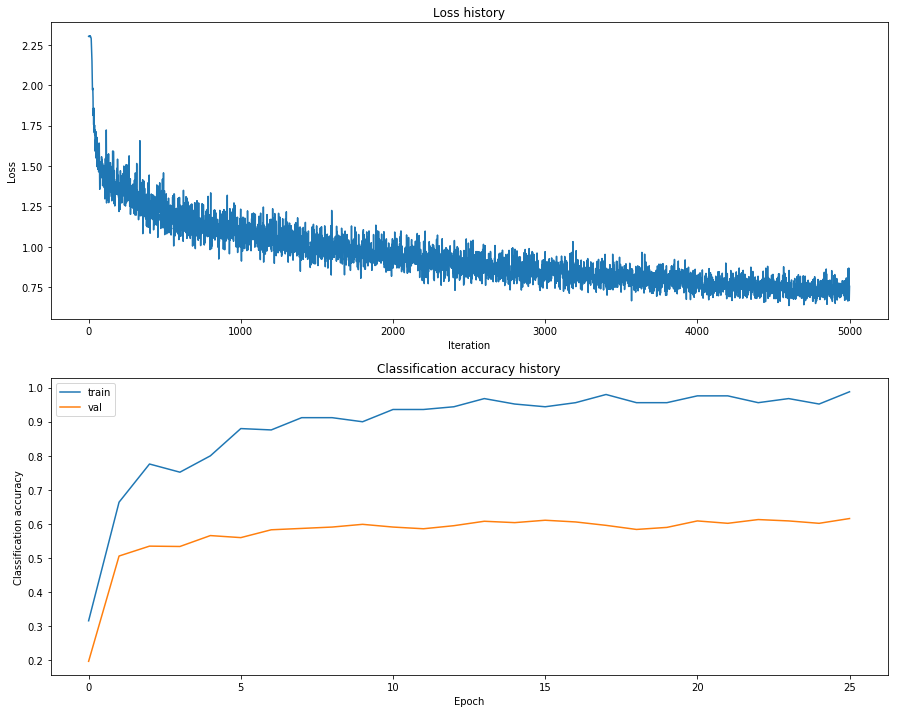

In [55]:
# Plot the loss function and train / validation accuracies
plt.figure(figsize = (15, 12)) # added by me

plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [58]:
# decreasing complexity of model

t = time.time()
best_val = -1
best_hp = None
best_stats = None
info = pd.DataFrame(columns = ['num_iter', 'batch_size', 'accuracy_train', 'accuracy_val'])

l_rate = 1.0
reg = 0.0005
hidden_dim = 400

# hyperparameters
num_iters = [1000, 1200, 1600, 2000, 2400, 3000]
batch_sizes = [200, 250, 300, 400, 500]

n1, n2 = len(num_iters), len(batch_sizes)

for i in range(n1 * n2):
    tic = time.time()
    num_iter = num_iters[i // n2]
    batch_size = batch_sizes[i % n2]
    if num_iter % batch_size != 0: continue
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)       
    stats = net.train(
        X_train_feats, y_train, X_val_feats, y_val,
        num_iters = num_iter, batch_size = batch_size, learning_rate = l_rate, learning_rate_decay = 0.95,
        reg = reg, verbose = False
    )
        
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    accuracy_train = np.mean(y_train == y_train_pred)
    accuracy_val = np.mean(y_val == y_val_pred)
        
    if accuracy_val > best_val: 
        best_val, best_net, best_hp, best_stats = accuracy_val, net, (num_iter, batch_size), stats
    
    step = {
        'num_iter': [num_iter], 'batch_size': batch_size,
        'accuracy_train': accuracy_train, 'accuracy_val': accuracy_val
    }
    info = info.append(pd.DataFrame(step), ignore_index = True)
    
    acc = round(accuracy_val, 3)
    to_print = '{}{}. num_iter = {}{} | '.format(' ' * (4 - len(str(i))), i, ' ' * (4 - len(str(num_iter))), num_iter)
    to_print = to_print + 'batch_size = {}{}: '.format(' ' * (3 - len(str(batch_size))), batch_size)    
    to_print = to_print + 'Accuracy {}{}.'.format(' ' * (5 - len(str(acc))), acc)
    toc = round(time.time() - tic, 2)
    if i % n2 == 0 and i != 0: print ()
    print('{} That took {}{} sec.'.format(to_print, ' ' * (6 - len(str(toc))), toc))
tt = round(time.time() - t, 0)
print
print(best_val, best_hp)
print('Total time: {} min. {} sec.'.format(tt // 60, tt % 60))

   0. num_iter = 1000 | batch_size = 200: Accuracy 0.566. That took   4.55 sec.
   1. num_iter = 1000 | batch_size = 250: Accuracy 0.572. That took   5.26 sec.
   4. num_iter = 1000 | batch_size = 500: Accuracy 0.588. That took  12.14 sec.

   5. num_iter = 1200 | batch_size = 200: Accuracy 0.556. That took   8.61 sec.
   7. num_iter = 1200 | batch_size = 300: Accuracy 0.572. That took  12.99 sec.
   8. num_iter = 1200 | batch_size = 400: Accuracy 0.581. That took  12.79 sec.

  10. num_iter = 1600 | batch_size = 200: Accuracy 0.589. That took   9.27 sec.
  13. num_iter = 1600 | batch_size = 400: Accuracy 0.574. That took  15.67 sec.

  15. num_iter = 2000 | batch_size = 200: Accuracy 0.582. That took  11.44 sec.
  16. num_iter = 2000 | batch_size = 250: Accuracy 0.575. That took  13.38 sec.
  18. num_iter = 2000 | batch_size = 400: Accuracy 0.615. That took  19.27 sec.
  19. num_iter = 2000 | batch_size = 500: Accuracy 0.577. That took  28.26 sec.

  20. num_iter = 2400 | batch_size =

In [57]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.581
